In [31]:
# SLOT 1: Setup & Load Data
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# อ่านไฟล์ CSV (ไฟล์ต้องอยู่โฟลเดอร์เดียวกับ notebook หรือ /content/ ใน Colab)
df = pd.read_csv("dataset\Sleep_data__norm_ML2568.csv")
print("Loaded dataset shape:", df.shape)

# drop col with no norm in its name and print the dropped names
cols_to_drop = [col for col in df.columns if 'norm' not in col]
df = df.drop(columns=cols_to_drop)
print("Dataset shape after dropping non-norm columns:", df.shape)
print("Dropped columns:", cols_to_drop)


Loaded dataset shape: (11470, 143)
Dataset shape after dropping non-norm columns: (11470, 137)
Dropped columns: ['Unnamed: 0', 'pid', 'date', 'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday', 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday', 'date_']


In [32]:
# SLOT 2: Cleaning & Preprocessing

# 2.1 ดรอปคอลัมน์ที่ missing > 50%
missing_ratio = df.isnull().sum() / len(df)
df = df.loc[:, missing_ratio <= 0.5]
print("After dropping high-missing cols shape:", df.shape)

# 2.2 แยก numeric / non-numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 2.3 เติม missing ของ numeric ด้วย median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("After cleaning shape:", df.shape)
print("Still missing: ", df.isnull().sum().sum(), "cells")
df.head()


After dropping high-missing cols shape: (11470, 75)
After cleaning shape: (11470, 75)
Still missing:  0 cells


,f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday,f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:allday,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:afternoon,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:evening,f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:morning,f_loc:phone_locations_doryab_movingtostaticratio_norm:afternoon,f_loc:phone_locations_doryab_timeathome_norm:afternoon,f_loc:phone_locations_doryab_totaldistance_norm:afternoon,f_loc:phone_locations_locmap_duration_in_locmap_study_norm:afternoon,...,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:allday,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:evening,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:evening,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:evening,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:morning,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:morning,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:morning,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:night,f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:night,f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout_norm:night
0,0.141844,-0.294479,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.166485,0.019403,0.363636,0.019737,-0.203456,-0.310345,-0.315789,0.938046,0.607143,0.818505
1,-0.425532,-0.147239,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.002729,-0.133076,-0.242424,-0.256579,0.713246,-0.103448,0.210526,0.275539,0.785714,0.344009
2,0.141844,0.392638,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.092795,0.196206,0.424242,0.190789,0.393885,0.034483,0.105263,0.178433,0.321429,0.189798
3,0.283688,-0.273006,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.030022,0.069661,-0.090909,-0.006579,-0.206330,0.000000,0.000000,0.173092,0.285714,0.201661
4,0.141844,0.472393,0.0,0.0,0.0,0.0,0.000024,0.0,-0.000246,0.0,...,0.322052,0.337990,-0.090909,0.217105,0.062263,0.241379,0.017544,0.314381,0.535714,0.450771


In [33]:
# SLOT 3: Feature / Target Split

target_col = 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday'

X = df.drop(columns=[target_col], errors='ignore')
y = df[target_col]

# เก็บเฉพาะคอลัมน์เชิงตัวเลข (MLP รับแต่ตัวเลข)
X = X.select_dtypes(include=[np.number])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example feature columns:", list(X.columns[:8]))
df.columns.to_series().to_csv("column_names.csv", index=False, header=["column_name"])


X shape: (11470, 74)
y shape: (11470,)
Example feature columns: ['f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:allday', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:afternoon', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:evening', 'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:morning', 'f_loc:phone_locations_doryab_movingtostaticratio_norm:afternoon', 'f_loc:phone_locations_doryab_timeathome_norm:afternoon', 'f_loc:phone_locations_doryab_totaldistance_norm:afternoon']


In [34]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


Train: (9176, 74) Test: (2294, 74)
Model trained.
Sleep Duration Prediction Performance
MAE  : 0.2323
RMSE : 0.3254
R²   : -0.5436


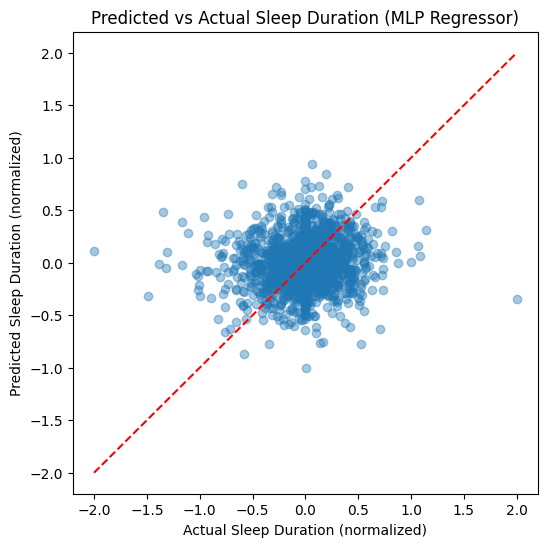

['model_mlp.pkl']

In [35]:
# SLOT 4: Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# SLOT 5: Scaling + Train Model

# สร้าง scaler และแปลงข้อมูลให้เป็นสเกลมาตรฐาน (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# สร้างโมเดล MLP Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),  # network ลึกขึ้นกว่าของเดิม
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter=10000,     # ให้เรียนรู้ได้นานขึ้น
    random_state=42
)

# เทรนโมเดล
mlp.fit(X_train_scaled, y_train)

print("Model trained.")

# SLOT 6: Evaluation

# พยากรณ์บน test set
y_pred = mlp.predict(X_test_scaled)

# คำนวณ metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("Sleep Duration Prediction Performance")
print(f"MAE  : {mae:.4f}")   # ต่ำ = ดี
print(f"RMSE : {rmse:.4f}")  # ต่ำ = ดี
print(f"R²   : {r2:.4f}")    # ใกล้ 1 = ดี

# SLOT 7: Plot Predicted vs Actual

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Sleep Duration (normalized)")
plt.ylabel("Predicted Sleep Duration (normalized)")
plt.title("Predicted vs Actual Sleep Duration (MLP Regressor)")

# เส้น y = x (ทำนายตรงเป๊ะ)
low  = min(y_test.min(), y_pred.min())
high = max(y_test.max(), y_pred.max())
plt.plot([low, high], [low, high], 'r--')

plt.show()

# save model
joblib.dump(mlp, "model_mlp.pkl")

XGBoost model trained successfully.
XGBoost Sleep Duration Prediction Performance
MAE  : 0.1626
RMSE : 0.2680
R²   : -0.0468


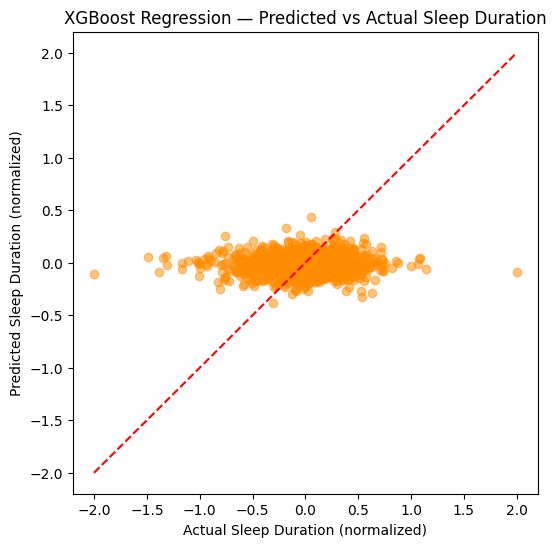

['model_xgb.pkl']

In [36]:
# SLOT 8: Train XGBoost (ต่อจาก MLP เดิมได้เลย)
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.3,
    random_state=42,
    tree_method='hist'
)

xgb_model.fit(X_train_scaled, y_train)
print("XGBoost model trained successfully.")

# SLOT 9: Evaluate XGBoost Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_xgb = xgb_model.predict(X_test_scaled)

mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb   = r2_score(y_test, y_pred_xgb)

print("XGBoost Sleep Duration Prediction Performance")
print(f"MAE  : {mae_xgb:.4f}")
print(f"RMSE : {rmse_xgb:.4f}")
print(f"R²   : {r2_xgb:.4f}")

# SLOT 10: Visualization (XGBoost)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='darkorange')
plt.xlabel("Actual Sleep Duration (normalized)")
plt.ylabel("Predicted Sleep Duration (normalized)")
plt.title("XGBoost Regression — Predicted vs Actual Sleep Duration")

# เส้นอ้างอิง y=x
low, high = min(y_test.min(), y_pred_xgb.min()), max(y_test.max(), y_pred_xgb.max())
plt.plot([low, high], [low, high], 'r--')
plt.show()

# save model
joblib.dump(xgb_model, "model_xgb.pkl")

Decision Tree model trained successfully.
Decision Tree Sleep Duration Prediction Performance
MAE  : 0.1671
RMSE : 0.2850
R²   : -0.1840


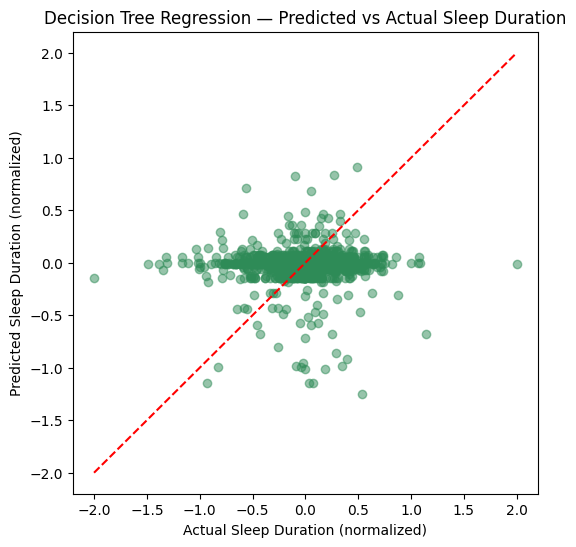

['model_rf.pkl']

In [37]:
# SLOT 11: Train Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(
    max_depth=10,          # ควบคุมความลึกของต้นไม้ (ลึกเกิน = overfit)
    min_samples_split=5,   # จำนวน sample ขั้นต่ำก่อน split
    min_samples_leaf=3,    # จำนวน sample ขั้นต่ำใน leaf node
    random_state=42
)

tree_model.fit(X_train_scaled, y_train)
print("Decision Tree model trained successfully.")

# SLOT 12: Evaluate Decision Tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_tree = tree_model.predict(X_test_scaled)

mae_tree  = mean_absolute_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree   = r2_score(y_test, y_pred_tree)

print("Decision Tree Sleep Duration Prediction Performance")
print(f"MAE  : {mae_tree:.4f}")
print(f"RMSE : {rmse_tree:.4f}")
print(f"R²   : {r2_tree:.4f}")

# SLOT 13: Plot Decision Tree Predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_tree, alpha=0.5, color='seagreen')
plt.xlabel("Actual Sleep Duration (normalized)")
plt.ylabel("Predicted Sleep Duration (normalized)")
plt.title("Decision Tree Regression — Predicted vs Actual Sleep Duration")

low, high = min(y_test.min(), y_pred_tree.min()), max(y_test.max(), y_pred_tree.max())
plt.plot([low, high], [low, high], 'r--')
plt.show()

# save model
joblib.dump(tree_model, "model_rf.pkl")


In [38]:
# SLOT 14: Train Linear Regression
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

print("Linear Regression model trained successfully.")

# SLOT 15: Evaluate Linear Regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_lin = lin_model.predict(X_test_scaled)

mae_lin  = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin   = r2_score(y_test, y_pred_lin)

print("Linear Regression Sleep Duration Prediction Performance")
print(f"MAE  : {mae_lin:.4f}")
print(f"RMSE : {rmse_lin:.4f}")
print(f"R²   : {r2_lin:.4f}")

# save model
joblib.dump(lin_model, "model_linear.pkl")

Linear Regression model trained successfully.
Linear Regression Sleep Duration Prediction Performance
MAE  : 0.1620
RMSE : 0.2620
R²   : -0.0009


['model_linear.pkl']

In [39]:
# SLOT 17: Compare All Models
results = pd.DataFrame({
    'Model': ['MLP', 'XGBoost', 'DecisionTree', 'LinearRegression'],
    'MAE':   [mae, mae_xgb, mae_tree, mae_lin],
    'RMSE':  [rmse, rmse_xgb, rmse_tree, rmse_lin],
    'R²':    [r2, r2_xgb, r2_tree, r2_lin]
})

results = results.sort_values(by='R²', ascending=False)
print(results)


              Model       MAE      RMSE        R²
3  LinearRegression  0.162015  0.262045 -0.000938
1           XGBoost  0.162616  0.267985 -0.046831
2      DecisionTree  0.167122  0.285005 -0.184020
0               MLP  0.232306  0.325417 -0.543604
